In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from scipy.fft import rfft, irfft
from scipy import signal
from numpy.random import default_rng
from scipy import stats
import thztools as thz
%matplotlib inline

In [2]:
n_sim = 10
n = 256
n_p = 2

dt = 0.05
t0 = 2.5 
fs = 1/dt

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])


seed = 0  # RNG seed
rng = default_rng(seed)

In [3]:
mu, t = thz.wave(n, dt, t0)
noise_mod = thz.NoiseModel(sigma_alpha, sigma_beta, sigma_tau, dt)
sigma = noise_mod.amplitude(mu)

# Use broadcasting to generate multiple simulated noisy measurements of y
x = mu + sigma * rng.standard_normal((n_sim, n))

# Compute power spectral density
f, psd = signal.periodogram(x, fs=fs, detrend=False)
n_f = f.size

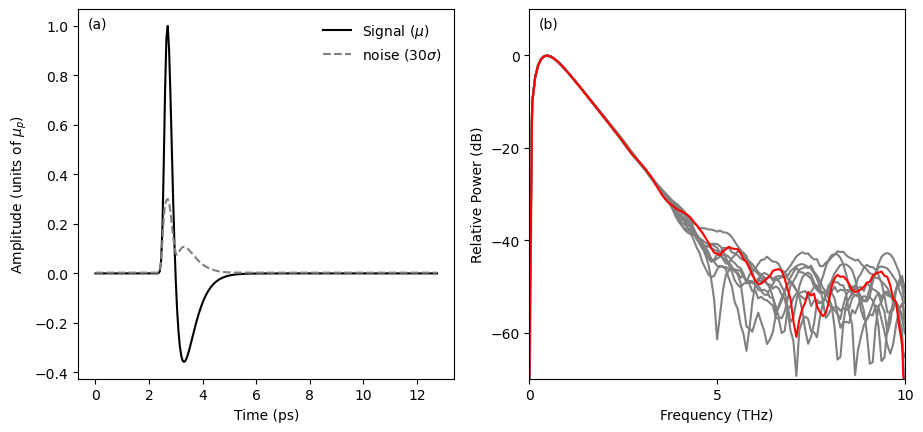

In [4]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(t, mu, c='k', label=r'Signal ($\mu$)')
axs[0].plot(t, sigma * 30, ls='--', c='grey', label=r'noise $(30 \sigma$)')

axs[0].legend(frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlabel('Time (ps)')
axs[0].set_ylabel(r'Amplitude (units of $\mu_{p})$')

axs[1].plot(f, 10 * np.log10(psd[1:, :].T / max(psd.flatten())), c='grey')
axs[1].plot(f, 10 * np.log10(psd[0, :].T / max(psd.flatten())), c='red')

axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlabel('Frequency (THz)')
axs[1].set_ylabel('Relative Power (dB)')

axs[1].set_xticks(np.arange(0, 11, 5))
axs[1].set_xlim(0, 10)
axs[1].set_yticks(np.arange(-60, 10, 20))
axs[1].set_ylim(-70, 10)

plt.show()
del x

In [5]:
def transfer(_f, _a, _eta):
    _w = 2*np.pi*_f
    return _a * np.exp(-1j * _w * _eta)

In [6]:
a = 1
eta = 0.5
n_sim = 1024
# plt.figure(figsize=(9,6))
# plt.plot(f, np.real(transfer(f,a,eta)))
# plt.plot(f, np.imag(transfer(f,a,eta)))
# plt.show()

In [7]:
rng = default_rng(seed)

sigma_psi = np.empty((n_sim, n))
sigma_mu = np.empty((n_sim, n))
amp_shifted = np.empty((n_sim, n))
amp = np.empty((n_sim, n))
amp_shifted_noise = np.empty((n_sim, n))
amp_noise = np.empty((n_sim, n))

psi = irfft(rfft(mu)*transfer(f,a,eta), n=n)
sigma_psi = noise_mod.amplitude(psi)

amp_shifted_noise = sigma_psi * rng.standard_normal((n_sim, n))
amp_shifted = psi + amp_shifted_noise

sigma_mu = noise_mod.amplitude(mu)

amp_noise = sigma_mu * rng.standard_normal((n_sim, n))
amp = mu + amp_noise

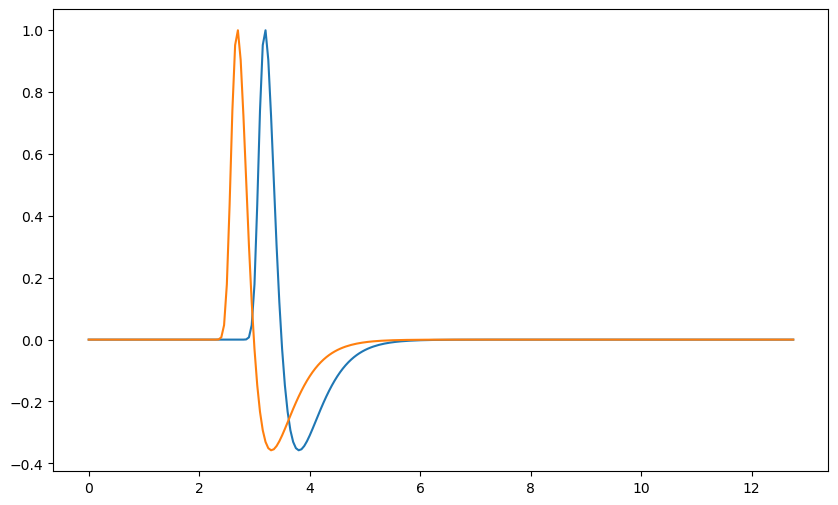

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(t, psi)
plt.plot(t, mu)
plt.show()

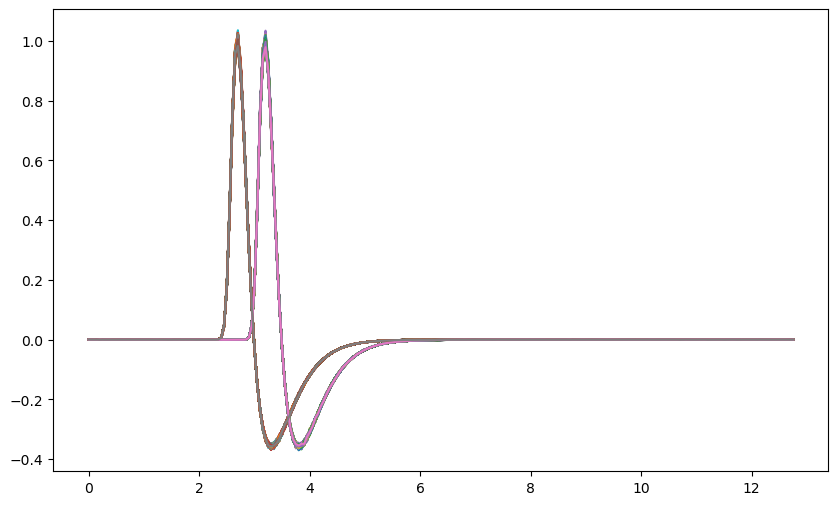

In [9]:
plt.figure(figsize=(10, 6))
for i in range(n_sim):
    plt.plot(t, amp_shifted[i, :])
    plt.plot(t, amp[i, :])
plt.show()

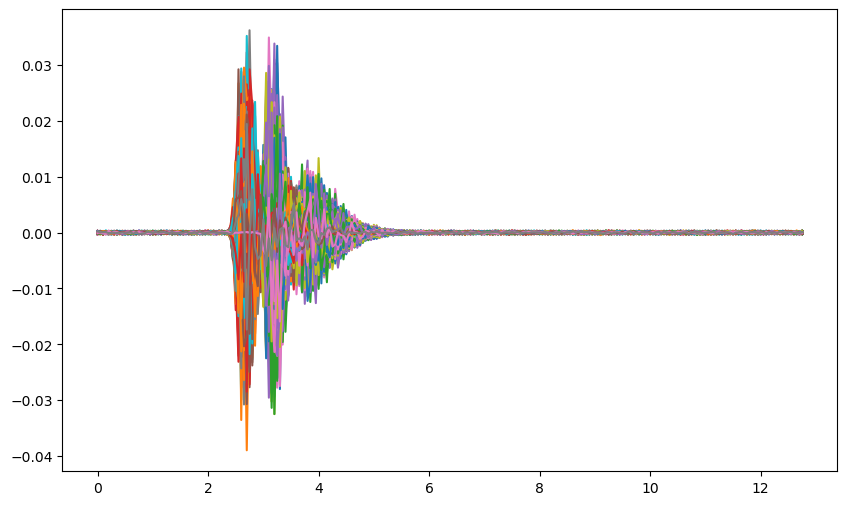

In [10]:
plt.figure(figsize=(10, 6))
for i in range(n_sim):
    plt.plot(t, amp_shifted_noise[i, :])
    plt.plot(t, amp_noise[i, :])
plt.show()

In [11]:
# Creating empty arrays to store the fit results
p_tls = np.empty((n_p, n_sim))
sigma_p_tls = np.empty((n_p, n_sim))
mu_tls = np.empty((n, n_sim))
sigma_mu_tls = np.empty((n, n_sim))
resnorm_tls = np.empty(n_sim)
delta_tls = np.empty((n, n_sim))
epsilon_tls = np.empty((n, n_sim))

In [12]:
# Defining the transfer function in frequency domain
def fit_fun(_p, _w):
    _f = _w/(2*np.pi)
    _y = transfer(_f, _p[0], _p[1])
    return _y

In [13]:
for i in range(n_sim):
    # print(i)
    x = amp[i]
    y = amp_shifted[i]

    if i == 0:
        initial_guess = [2, 0.5]
    else:
        initial_guess = p_tls[:,  i-1]
    
    result = thz.fit(fit_fun, initial_guess, x, y,
                     dt=dt, sigma_parms=sigma_parms, f_bounds=(-1, np.inf))
    
    p_tls[:, i] = result["p_opt"]
    mu_tls[:, i] = result["mu_opt"]
    sigma_p_tls[:, i] = np.sqrt(result["p_var"])
    sigma_mu_tls[:, i] = np.sqrt(result["mu_var"])
    delta_tls[:, i] = result["delta"]
    epsilon_tls[:, i] = result["epsilon"]
    resnorm_tls[i] = result["resnorm"]
    if not result["success"]:
        print(f"Fit did not converge at i = {i}")

cf_tls = stats.cumfreq(resnorm_tls, 1000, defaultreallimits=(0, 1000))
gof_tls = cf_tls.lowerlimit + np.linspace(
    0, cf_tls.binsize * cf_tls.cumcount.size, cf_tls.cumcount.size
)
ecdf_tls = cf_tls.cumcount / n_sim

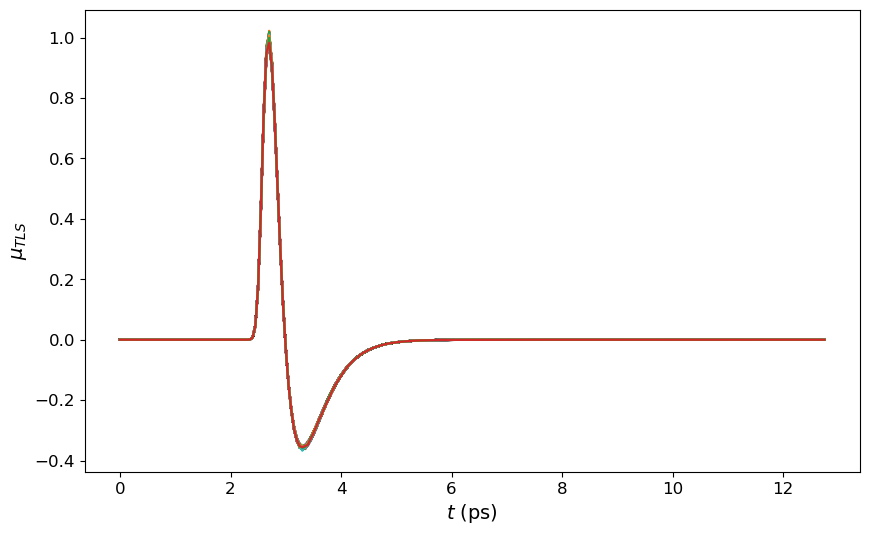

In [14]:
plt.figure(figsize=(10,  6))
for i in range(n_sim):
    plt.plot(t, mu_tls[:,  i])

plt.ylabel('$\mu_{TLS}$', fontsize=14)
plt.xlabel("$t$ (ps)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

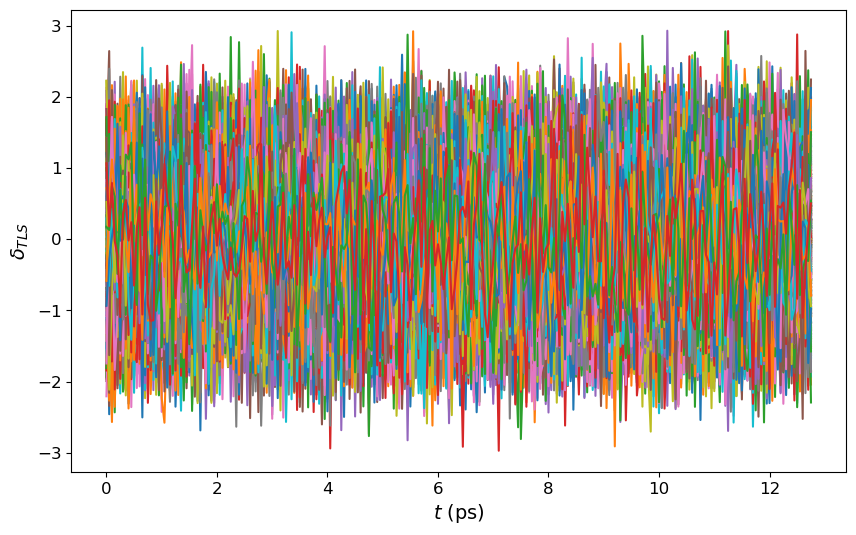

In [15]:
plt.figure(figsize=(10,  6))
for i in range(n_sim):
    plt.plot(t, delta_tls[:,  i] / noise_mod.amplitude(amp[i]))
plt.ylabel('$\delta_{TLS}$', fontsize=14)
plt.xlabel("$t$ (ps)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

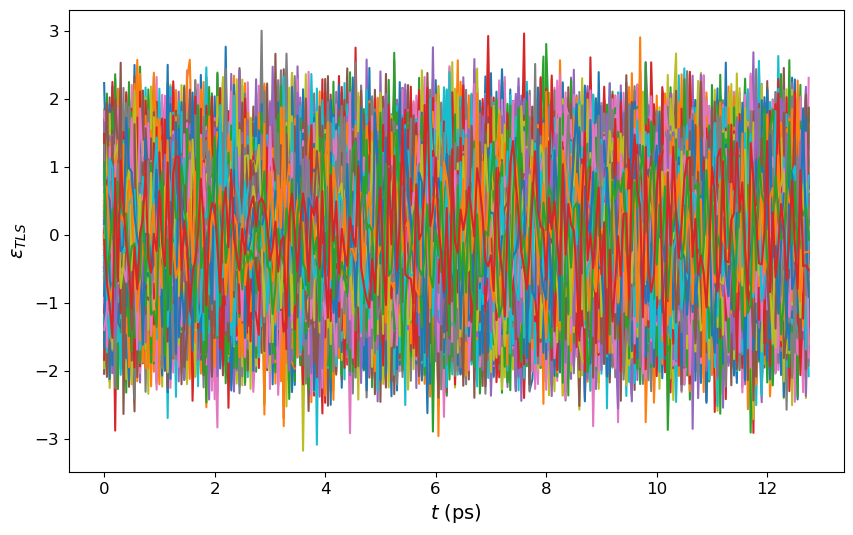

In [16]:
plt.figure(figsize=(10,  6))
for i in range(n_sim):
    plt.plot(t, epsilon_tls[:,  i] / noise_mod.amplitude(amp_shifted[i]))
plt.ylabel('$\epsilon_{TLS}$', fontsize=14)
plt.xlabel("$t$ (ps)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

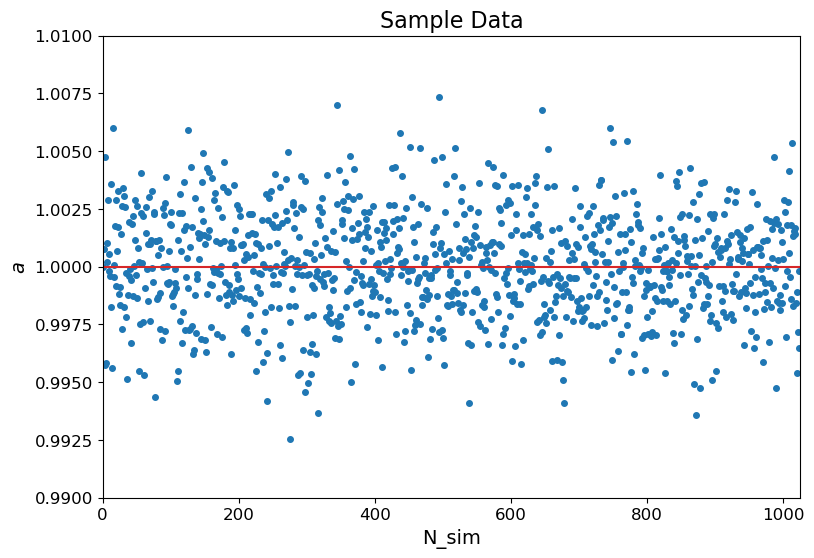

In [17]:
n_sim_arr = np.arange(1,  n_sim+1 , 1)
plt.figure(figsize=(9,  6))
plt.plot(n_sim_arr, p_tls[0,  :], 'o', markersize=4)
plt.hlines(a, 0, n_sim+1, colors='C3')
plt.title("Sample Data", fontsize=16)
plt.ylabel('$a$', fontsize=14)
plt.xlabel("N_sim", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,  n_sim+1)
plt.ylim(0.99,1.01)
plt.show()

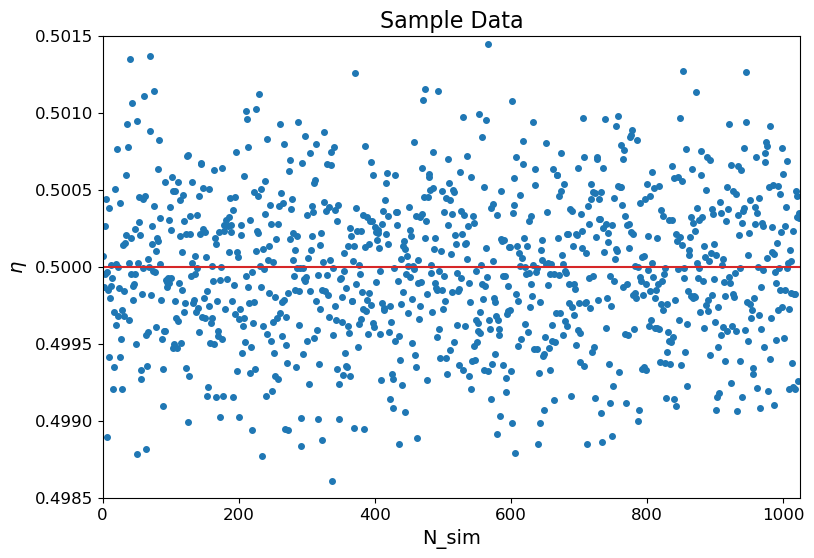

In [18]:
n_sim_arr = np.arange(1,  n_sim+1 , 1)
plt.figure(figsize=(9,  6))
plt.plot(n_sim_arr, p_tls[1,  :], 'o', markersize=4)
plt.hlines(eta, 0, n_sim+1, colors='C3')
plt.title("Sample Data", fontsize=16)
plt.ylabel('$\eta$', fontsize=14)
plt.xlabel("N_sim", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,  n_sim+1)
plt.ylim(0.4985,0.5015)
plt.show()

In [19]:
print('Mean of $a$ = {0:.4f}'.format(np.mean(p_tls[0, :])))
print('Stdev of $a$ = {0:.4f}'.format(np.std(p_tls[0, :])))
print('Mean uncertainty estimate of $a$ = {0:.4f}'.format(
    np.mean(sigma_p_tls[0,:])))
print()
print('Mean of $\eta$ = {0:.5f}'.format(np.mean(p_tls[1, :])))
print('Stdev of $\eta$ = {0:.5f}'.format(np.std(p_tls[1, :])))
print('Mean uncertainty estimate of $\eta$ = {0:.5f}'.format(
    np.mean(sigma_p_tls[1,:])))
print()


Mean of $a$ = 1.0000
Stdev of $a$ = 0.0022
Mean uncertainty estimate of $a$ = 0.0023

Mean of $\eta$ = 0.49998
Stdev of $\eta$ = 0.00050
Mean uncertainty estimate of $\eta$ = 0.00044



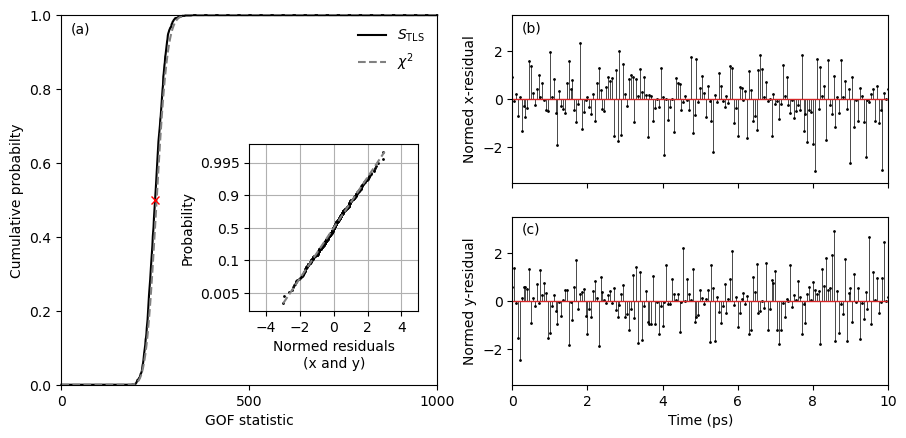

In [20]:
# Find the index of the median value
i_show = np.argsort(resnorm_tls)[len(resnorm_tls) // 2]
norm_res_eps = np.sqrt(
    512 / 254) * epsilon_tls[:, i_show] / noise_mod.amplitude(amp_shifted[i_show])
norm_res_delta = np.sqrt(
    512 / 254) * delta_tls[:, i_show] / noise_mod.amplitude(amp[i_show])
osm, osr = stats.probplot(
    np.concatenate((norm_res_eps, norm_res_delta)), fit=False
)

w, h = figaspect(0.45)
_, axd = plt.subplot_mosaic(
    [["CDF", "x-res"], ["CDF", "y-res"]], figsize=(w, h)
)

# Panel (a)
axd["CDF"].plot(
    gof_tls, ecdf_tls, 'k-', label=r'$S_\mathrm{TLS}$', clip_on=False
)
axd["CDF"].plot(
    gof_tls,
    stats.chi2.cdf(gof_tls, n - n_p),
    '--',
    c='gray',
    label=r'$\chi^2$',
    clip_on=False,
)
axd["CDF"].plot(np.median(resnorm_tls), 0.5, 'rx')

axd["CDF"].legend(loc='upper right', frameon=False)
axd["CDF"].text(0.025, 0.95, '(a)', transform=axd["CDF"].transAxes)

axd["CDF"].set_xlim(0, 1000)
axd["CDF"].set_ylim(0, 1)

axd["CDF"].set_xticks([0, 500, 1000])
axd["CDF"].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axd["CDF"].set_xlabel('GOF statistic')
axd["CDF"].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axd["CDF"].inset_axes([0.5, 0.2, 0.45, 0.45])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-5, 5)
ins.set_ylim(stats.norm.ppf([0.0005, 0.9995]))

ins.set_xticks(np.arange(-4, 4.5, 2))
ins.set_yticks(stats.norm.ppf([0.005, 0.1, 0.5, 0.9, 0.995]))

ins.set_yticklabels(['0.005', '0.1', '0.5', '0.9', '0.995'])

ins.set_xlabel('Normed residuals\n(x and y)')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axd["x-res"].stem(
    t, norm_res_delta, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["x-res"].text(0.025, 0.9, '(b)', transform=axd["x-res"].transAxes)

axd["x-res"].set_xlim(0, 10)
axd["x-res"].set_ylim(-3.5, 3.5)

axd["x-res"].set_xticklabels([])
axd["x-res"].set_ylabel('Normed x-residual')

# Panel (c)
markerline, stemlines, baseline = axd["y-res"].stem(
    t, norm_res_eps, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["y-res"].text(0.025, 0.9, '(c)', transform=axd["y-res"].transAxes)

axd["y-res"].set_xlim(0, 10)
axd["y-res"].set_ylim(-3.5, 3.5)

axd["y-res"].set_xlabel('Time (ps)')
axd["y-res"].set_ylabel('Normed y-residual')

plt.show()

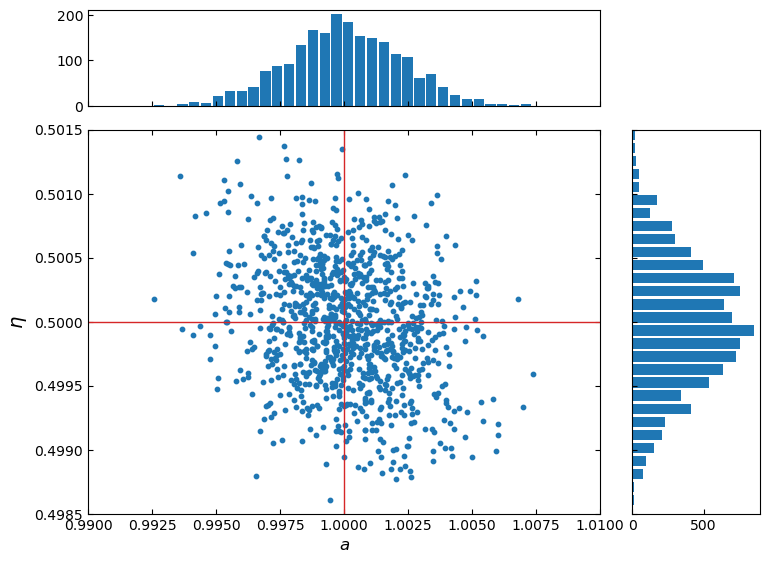

In [21]:
j=(np.max(p_tls[0, :])-np.min(p_tls[0, :]))*(2/3)
k=(np.max(p_tls[1, :])-np.min(p_tls[1, :]))*(2/3)
# definitions for the axes
left, width = 0.1, 0.8
bottom, height = 0.1, 0.8
spacing = 0.05


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
# plt.figure(figsize=(8, 8))


ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.hlines(eta,0.99, 1.01, colors="C3", linewidth=1)
ax_scatter.vlines(a,0.4985, 0.5015, colors="C3", linewidth=1)
ax_scatter.scatter(p_tls[0, :], p_tls[1, :], s=10, marker='o')
ax_scatter.set_xlabel('$a$', fontsize=12)
ax_scatter.set_ylabel('$\eta$', fontsize=14)


# now determine nice limits by hand:
# ax_scatter.set_xlim(15-j, 15+j)
# ax_scatter.set_ylim(0.2-k, 0.2+k)
ax_scatter.set_xlim(0.99, 1.01)
ax_scatter.set_ylim(0.4985, 0.5015)

bins = int(np.sqrt(n_sim))
ax_histx.hist(p_tls[0, :], bins=bins, density=True, width=0.0004)
ax_histy.hist(p_tls[1, :], bins=bins, density=True,
              height=0.00008, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()